In [1]:
# Python
import itertools
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from autots import AutoTS
import matplotlib.pyplot as plt 
import funciones
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
df_main = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_main = df_main.sort_values("FECHA",ascending=True)
df_main.set_index("FECHA", inplace=True)
df_copa = df_main["CHU_COPA_AJUST"].dropna()
df_recprop = df_main["CHU_REC_PROPIOS_AJUST"].dropna()
df_regal = df_main["CHU_REGALIAS_AJUST"].dropna()
dataframes = [df_copa, df_recprop, df_regal]
for i in range(len(dataframes)):
  dataframes[i] = dataframes[i].reindex(pd.date_range(start=dataframes[i].index.min(), end=dataframes[i].index.max(), freq='B'))
  dataframes[i] = dataframes[i].fillna(0)
    
titulos = ["CHU_COPA_AJUST", "CHU_REC_PROPIOS_AJUST", "CHU_REGALIAS_AJUST"]

In [3]:
# TRAIN TEST
n_test = 30
train_copa = dataframes[0].iloc[:-n_test]
test_copa = dataframes[0].iloc[-n_test:]
print(f"Coparticipacion: train({train_copa.shape}), test({test_copa.shape})")

train_recursos = dataframes[1].iloc[:-n_test]
test_recursos = dataframes[1].iloc[-n_test:]
print(f"Recursos: train({train_recursos.shape}), test({test_recursos.shape})")

train_regalias = dataframes[2].iloc[:-n_test]
test_regalias = dataframes[2].iloc[-n_test:]
print(f"Regalias: train({train_regalias.shape}), test({test_regalias.shape})")

dataframes_train = [ train_copa, train_recursos, train_regalias ]
dataframes_test = [ test_copa, test_recursos, test_regalias ]

Coparticipacion: train((1730,)), test((30,))
Recursos: train((2187,)), test((30,))
Regalias: train((2176,)), test((30,))


In [4]:
from nixtla import NixtlaClient
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-P7309LQjFeXHr6GYXQlH41AsZEadk15X66HvvheepbODf11yrBGLBt6bPxX4UgCKzq3UNHgFBAJbVSBG'
)

In [5]:
results_train_test = []
predictions_test = []
forecast = []
for i, df in enumerate(dataframes_train):
    name = df.name
    df_train = df.to_frame()
    df_train = df_train.reset_index()
    df_test = dataframes_test[i]
    fechas = pd.date_range(start=df_test.index.min(), end=df_test.index.max(), freq='B')
    
    response = nixtla_client.forecast(
    df=df_train,  # Entrenamiento solo con los datos de train
    time_col="index",  # Nombre del índice de tiempo (columna de fecha)
    target_col=name,  # Columna objetivo
    freq="B",  # Frecuencia de los datos (diaria)
    h=len(fechas),  # El tamaño del conjunto de test
    level=[80],  # Niveles de confianza
    finetune_loss='rmse',
    finetune_steps=20,
    )
    # Convertir la respuesta a DataFrame
    forecast_df = pd.DataFrame(response)
    forecast.append(forecast_df)
    # Find the best parameters
    
    pred_test = forecast_df["TimeGPT"].values
    pred_test = pd.Series(pred_test, index=df_test.index)
    predictions_test.append(pred_test)
    # Cálculo del MSE en el conjunto de prueba
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    mse_test = mean_squared_error(df_test, pred_test)
    mae_test = mean_absolute_error(df_test, pred_test)
    rmse = np.sqrt(mean_squared_error(df_test, pred_test))
    results_train_test.append({
        "model": "TimeGPT",
        "name": name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_test": mape_test,
        "mse_test":mse_test,
        "mape_mean": mape_mean,
        "mae_test": mae_test,
        "rmse": rmse
    })



INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,model,name,len_train,len_test,mape_test,mse_test,mape_mean,mae_test,rmse
0,TimeGPT,CHU_COPA_AJUST,1730,30,1.25,"2,504,862,266,013.56",1.12,"1,283,498.05","1,582,675.67"
1,TimeGPT,CHU_REC_PROPIOS_AJUST,2187,30,1.90,"881,463,481,999.91",1.59,"789,059.56","938,862.87"
2,TimeGPT,CHU_REGALIAS_AJUST,2176,30,"8,908,123,590,758,549,684,224.00","39,539,174,937,060.45","6,257,919,916,697,384,386,560.00","3,870,396.91","6,288,018.36"


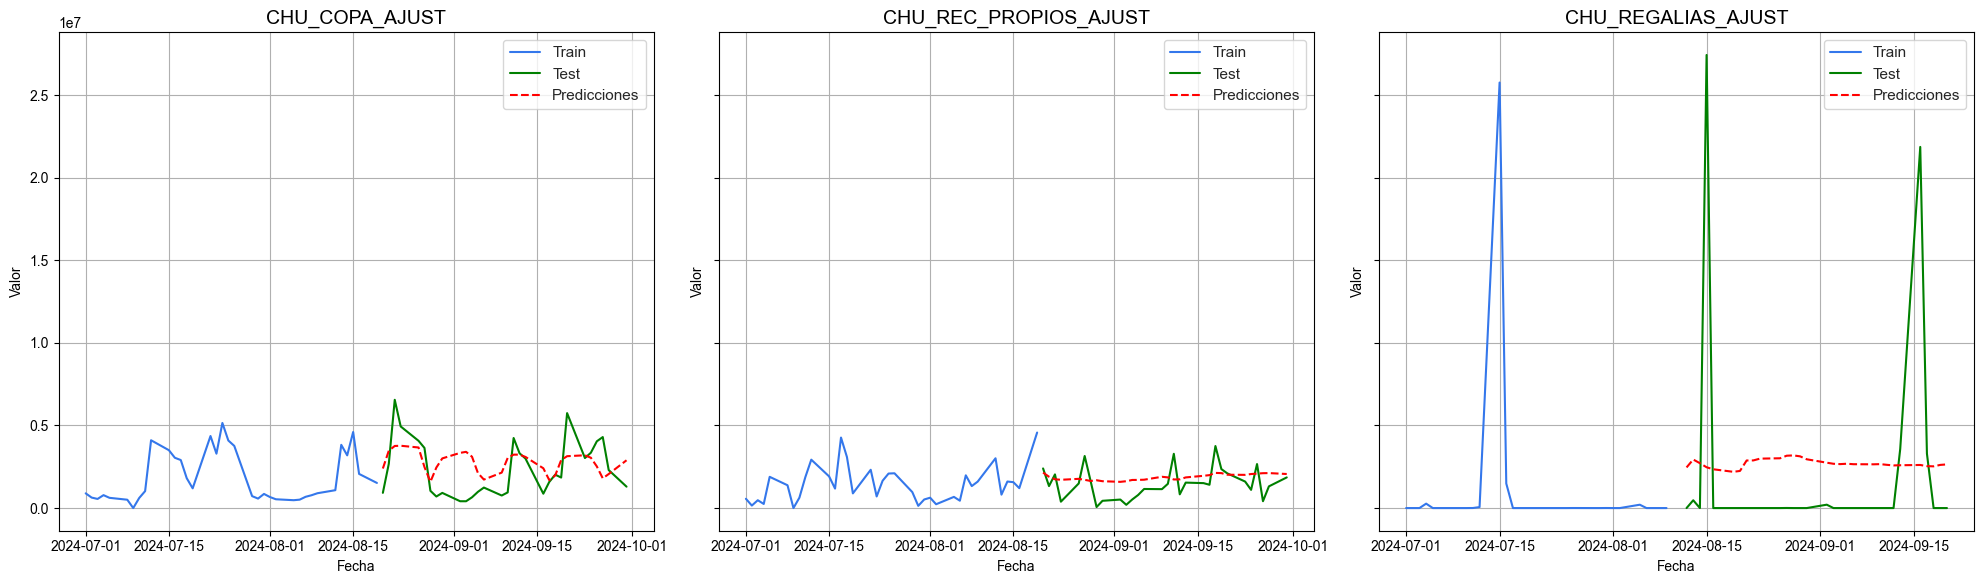

None

In [6]:
pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame(results_train_test))

display(funciones.plot_train_test_predictions(
    dataframes_train=dataframes_train,
    dataframes_test=dataframes_test,
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2024-07-01'
))

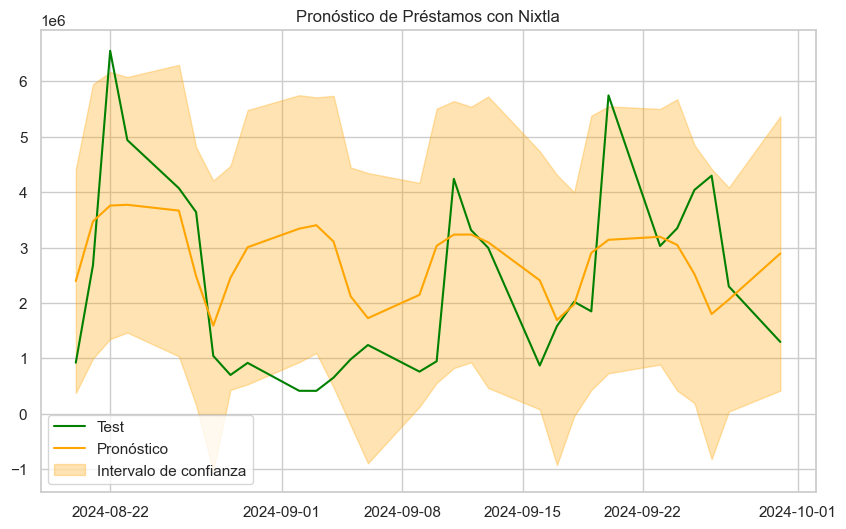

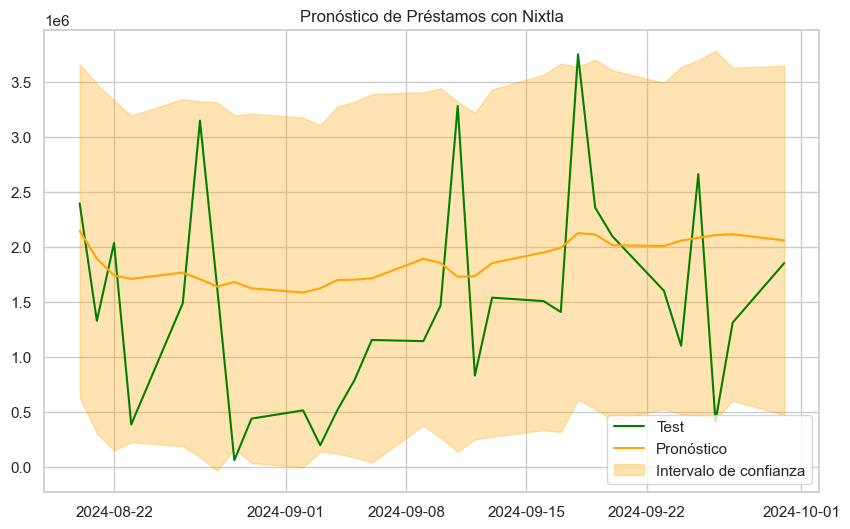

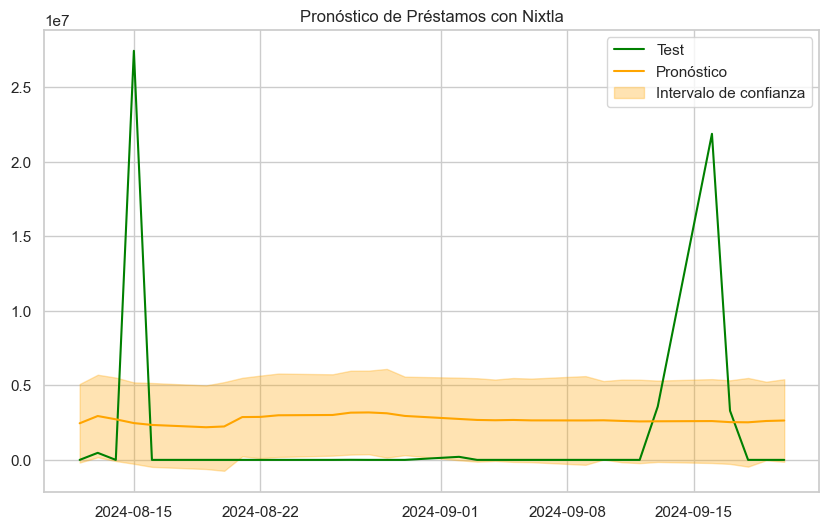

In [66]:
import matplotlib.pyplot as plt
def plot_pred(i):
  plt.figure(figsize=(10, 6))
  #plt.plot(train.index, train['CHU_COPA_AJUST'], label='Train', color='blue')
  plt.plot(dataframes_test[i].index, dataframes_test[i], label='Test', color='green')
  plt.plot(predictions_test[i].index, predictions_test[i], label='Pronóstico', color='orange')
  plt.fill_between(
      forecast[i]["index"],
      forecast[i]["TimeGPT-lo-80"],
      forecast[i]["TimeGPT-hi-80"],
      color='orange',
      alpha=0.3,
      label='Intervalo de confianza'
  )
  plt.legend()
  plt.title("Pronóstico de Préstamos con Nixtla")
  plt.show()
for i in range(len(dataframes_test)):
  plot_pred(i)